In [1]:
# %load ../uoicorr_imports.py
%load_ext autoreload
%autoreload 2

import h5py

import numpy as np
import matplotlib.pyplot as plt

import sys, os, pdb

# Hack to import pyuoi
parent_path, current_dir = os.path.split(os.path.abspath('.'))
while current_dir not in ['nse']:
	parent_path, current_dir = os.path.split(parent_path)
p = os.path.join(parent_path, current_dir)
# Add analysis
if p not in sys.path:
	sys.path.append(p)

# And standard list of subdirectories
if '%s\\pyuoi' % p not in sys.path:
	sys.path.append('%s\\pyuoi' % p)

from pyuoi.linear_model.lasso import UoI_Lasso
from pyuoi.linear_model.elasticnet import UoI_ElasticNet

if '%s\\uoicorr' % p not in sys.path:
    sys.path.append('%s\\uoicorr' % p)

from postprocess import postprocess_file, postprocess_dir

In [2]:
from utils import block_covariance

### Basic question to be answered: To what extent is there a relationship between the correlation of two variables and the magnitudes assigned by Elastic Net, UoI Elastic Net? What are the magnitudes of the false positives/false negatives of UoI Elastic Net and Elastic Net?

In [3]:
# Start with block correlati"ons, and see to what extent coefficient magnitudes are similar
uoien = postprocess_dir('C:\\Users\\akumar\\nse\\uoicorr\\data\\01132019b', True)

(120, 19)


In [4]:
en = postprocess_dir('C:\\Users\\akumar\\nse\\uoicorr\\data\\01142019b', True)

(120, 19)


In [10]:
uoien.iloc[0]

beta_hats               [[[5.968881261802955, 3.038212517676468, 8.906...
betadist                                                          uniform
betas                   [[7.296281384976813, 1.9578057283748973, 8.103...
block_size                                                              6
cov_params                                                              0
est_score                                                              r2
fn                      [[11.0], [10.0], [13.0], [12.0], [8.0], [14.0]...
fp                      [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....
kappa                                                                 0.3
l1_ratios                          [0.1, 0.2, 0.5, 0.75, 0.9, 0.95, 0.99]
n_alphas                                                               48
n_features                                                             60
n_samples                                                             300
r2                      [[0.6778849654

## Beginning with block size 6, for each sparsity, and for each correlation, find the the indices of false negatives for each repetition and the corresponding correlation (by reconstructing sigma)

In [5]:
d1 = uoien.loc[uoien['block_size'] == 6]

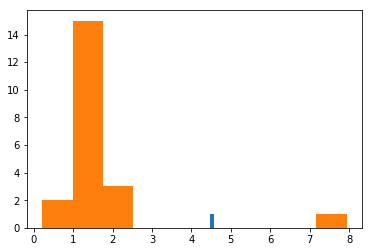

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


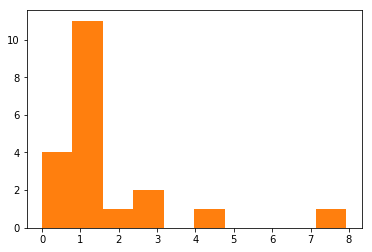

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


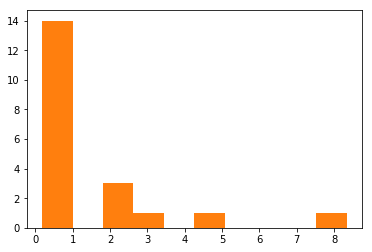

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


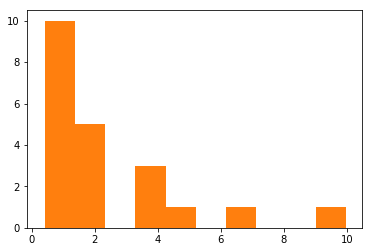

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


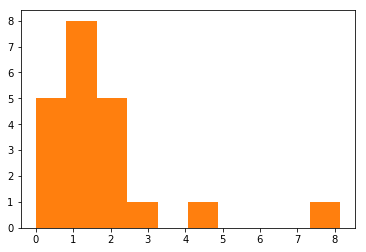

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


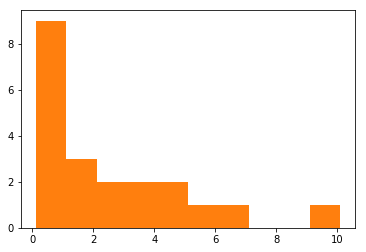

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


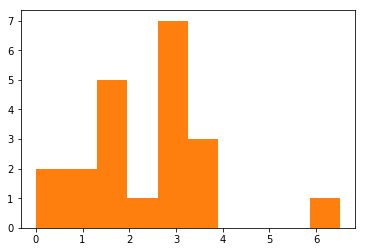

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


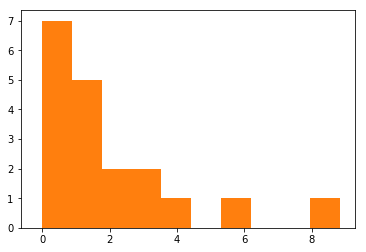

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) continue


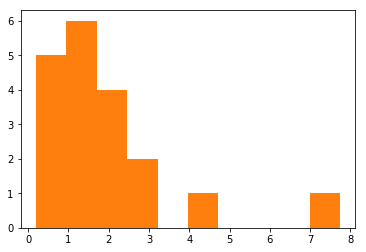

> <ipython-input-24-00c1a8cb7268>(30)<module>()
-> for idx in fp_indices:
(Pdb) corr_coeff_similarity
array([1.40716894, 1.40716894, 1.40716894])


In [ ]:
sparsity = np.unique(uoien['sparsity'])
correlation = np.unique(uoien['cov_params'])
block_size = 6
s1 = sparsity.size
s2 = correlation.size
for i, s in enumerate(sparsity):
    for j, c in enumerate(correlation):
        # Find the indices of false positives:
        dd = d1.loc[(d1['cov_params'] == c) & (d1['sparsity'] == s)]
        fp_indices = []

        # Reproduce the covariance matrix
        sigma = block_covariance(60, block_size, c)
        
        # Remove the diagonal
        sigma = sigma - np.diag(np.diag(sigma))
        
        for k in range(15):
            beta_hats = dd.iloc[0].beta_hats[k, :].ravel()
            betas = dd.iloc[0].betas[k, :].ravel()
            fp_indices = np.nonzero(np.multiply(beta_hats, 1 * (betas ==  0)))[0]
            # Having identified the nonzero indices, compare the magnitudes
            # of the estimated coefficients with that of variables that are
            # highly correlated with the variables within the block

            # If there are no false positives, continue
            if fp_indices.size == 0:
                continue

            for idx in fp_indices:

                # Find indices of variables that are highly correlated
                betaself = beta_hats[idx]
                sigma_row = sigma[idx, :].copy()
                block_idxs = np.nonzero(sigma_row)[0]
                if block_idxs.size == 0:
                    continue 
                other_idxs = np.setdiff1d(np.arange(sigma_row.size), block_idxs)
                block_coeffs = np.array([beta_hats[x] for x in np.nonzero(beta_hats[block_idxs])[0]])

                # How similar are the correlated coefficients?
                corr_coeff_similarity = abs(betaself - block_coeffs)

                # How similar are the coefficients outside of the block
                rand_coeffs = np.array([beta_hats[x] for x in np.nonzero(beta_hats[other_idxs])[0]])
                rand_coeff_similarity = abs(betaself - rand_coeffs)
                fig, ax = plt.subplots()
                ax.hist(corr_coeff_similarity)
                ax.hist(rand_coeff_similarity)
                plt.show()
                if block_idxs.size != 0:
                    pdb.set_trace()

### Does Elastic Net exhibit the grouping effect?

In [ ]:
sparsity = np.unique(en['sparsity'])
correlation = np.unique(en['cov_params'])
block_size = 6
s1 = sparsity.size
s2 = correlation.size
for i, s in enumerate(sparsity):
    for j, c in enumerate(correlation):
        # Find the indices of false positives:
        dd = d1.loc[(d1['cov_params'] == c) & (d1['sparsity'] == s)]
        fp_indices = []

        # Reproduce the covariance matrix
        sigma = block_covariance(60, block_size, c)
        
        # Remove the diagonal
        sigma = sigma - np.diag(np.diag(sigma))
        
        for k in range(50):
            plt.pcolor(dd.iloc[0].beta_hats[k, :]

In [2]:
import numpy as np

In [3]:
np.arange(1, 11)/10

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [6]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [8]:
type([1, 2, 3])

list

In [9]:
type({})

dict